<a href="https://colab.research.google.com/github/haechis/DeepLearning_tutorial/blob/main/Do_It_DeepLearning_201230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07-1 여러 개의 이미지를 분류하는 다층 신경망을 만듭니다.

- 스프트맥스 함수와 크로스 엔트로피 손실 함수라는 새로운 재료를 알아야한다.



## 다중 분류의 문제점과 소프트맥스 함수

- 분류: 자동차 , 비행기 , 로켓 이미지

- 분류 1) 출력층의 활성화값이 [0.9, 0.8, .0.7]

- 분류 2) 출력층의 활성화값이 [0.5, 0.2, 0.1]


- 분류 1)은 활성화값이 모두 높으면서 비슷 / 분류 2)는 활성화값이 대체적으로 낮지만 자동차 클래스의 값(확률)이 비교적 높다.


== 소프트맥스 함수 -> 출력 강도를 정규화
 
 - 전체 출력값의 합을 1로 만든다. 

## 크로스 엔트로피 손실 함수
 
- '로지스틱 엔트로피 손실 함수의 일반화 버전

- 크로스 엔ㅇ트로피 손실 함수를 미분하면 로지스틱 손실 함수의 미분과 일치한다.

- 예를 들기 위해서, MinibatchNetwork 클래스를 확장하여 다중 분류를 수행할 수 있는 MultiClassNetwork 클래스를 구현해 보자. // 소프트맥스 함수가 추가된것이다.



In [ ]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

## 의류 이미지를 분류하자.

- 패션 MNIST 데이터 세트 이용

- 패션 MNIST 데이터를 텐서플로에서 불러와 사용한다.



In [ ]:
# 텐서플로 최신 버전을 설치
!pip install tensorflow_gpu==2.0.0 

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 3.8MB 34.0MB/s 
     |████████████████████████████████| 450kB 46.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=402527b69ec9edee691849efa3e1ecce731a31999d93d3b6f8d89f50135ff9bb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorflow-estimator<2.5.0,>=2.4.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing insta

In [ ]:
## 의류데이터 준비

# 1. 텐스플로 임포트
import tensorflow as tf

In [ ]:
# 2. 텐서플로 버전 확인
tf.__version__

'2.0.0'

In [ ]:
# 3. 패션 MNIST 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# 4. 훈련 세트의 크기 확인하기
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


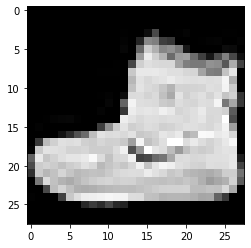

In [ ]:
# 5. imshow() 함수로 샘플 이미지 확인하기
# imshow() 함수는 넘파이 배열을 입력 받아 이미지를 그린다.
# cmap 매개변수: 픽셀 색 표현 / 디폴트는 viridis: 짙은 녹색에서 밝은 노란색 사이로 표현
# 여기서는 gray로 표현 / 0에 가까울수록 검은색
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0],cmap = 'gray')
plt.show()

In [ ]:
# 6. 타깃의 내용과 의미 확인하기
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
# 각 레이블의 의미는 다음과 같다.
class_names = ['티셔츠/윗도리','바지','스웨터','드레스','코트','샌들','셔츠','스니커즈','가방','앵클부츠']

In [ ]:
print(class_names[y_train_all[0]])

앵클부츠


In [ ]:
# 7. 타깃 분포 확인하기
# 넘파이 bincount() 함수를 사용하여 배열에 있는 정수값의 회수를 세어보자.
import numpy as np
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
# 훈련 세트와 검증 세트 고르게 나눠보자.
# -> 사이킷런의 train_test_split() 함수 사용
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all,y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [ ]:
# 훈련, 검증 세트의 레이블이 잘 나누어졌는지 확인
np.bincount(y_train)

np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [ ]:
# 9. 입력 데이터 정규화하기
# 이미지는 0~255 사이의 값을 나타낸다. -> 255로 나눈다.
# 엄밀히 정규화 한것은 아니지만 / 실전에 잘 작동하므로 이 방법을 많이 씀
x_train = x_train / 255
x_val = x_val / 255


In [ ]:
# 10. 훈련 세트와 검증 세트의 차원 변경하기
# 훈련세트와 검증세트의 샘플들은 28 x 28 크기의 2차원 배열이다. 
# 앞서 만든 MultiCalssNetwork는 1차원 배열의 샘플을 기대한다. 
# 넘파이의 reshape() 을 이용하여 훈련과 검증의 2,3번째 차원을 합쳐 784의 길이로 펼쳐보자.
x_train = x_train.reshape(-1,784)
x_val = x_val.reshape(-1,28*28)

In [ ]:
# 차원 확인
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


## 타깃 데이터를 준비하고 다중 분류 신경망을 훈련한다.

- 패션 MNIST 데이터 세트는 10개의 클래스 / 출력 뉴런의 개수도 10개가 되어야 한다.

- y_train, y_val의 값은 0 or 1 두 개 뿐 아니라 0~9 사이로 나타난다.


(1) 타깃을 원-핫 인코딩 변환하기

- 타깃값이 출력층의 10개 뉴런에 대응하는 배열이어야 한다. 

- 신경망의 출력값과 타깃값을 비교하려면 타깃값이 출력층의 10개 뉴런에 대응하는 배열이어야 한다.

- 하지만 y_train, y_val에 저장된 값들은 0~9 사이의 1개의 정수 이다. -> 10개의 뉴런에 대응하지 않음

- 해결: 타깃의 정수값에 해당하는 원소는 1 / 나머지는 0으로 하여 10개의 원소를 가진 배열을 만드는 것이다. ==> 원-핫 인코딩

In [ ]:
## 원-핫 인코딩
tf.keras.utils.to_categorical([0,1,3])

# 문자열 레이블은 이코딩하지 못한다.


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [ ]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [ ]:
# 첫 번째 레이블로 테스트
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:

fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

## 07-2 텐서플로와 케라스를 사용하여 신경망을 만들어보자

- 높은 성능을 가진 인공신경망 모델을 만들기 위해서는 전문적인 라이브러리를 사용해야 한다

- 케라스 AIP : 텐서플로를 좀 더 쉽게 사용하기 위함



In [ ]:
## 케라스
# 케라스는 딥러닝 패키지를 편리하게 사용하기 위해 만들어진 래퍼(Wrapper) 패키지이다.
# 대표적인 딥러닝 패키지인 텐서플로, 씨아노 등을 사용해 신경망을 구현하려면 꽤 많은 양의 코드를 입력해야한다.

# 예

# 훈련할 가중치 변수 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 옵티마이저 설정
optimizer = tf.optimizers.SGD(lr = 0.01)

# 에포크 횟수만큼 훈련
num_epochs = 10
for step in range(num_epochs):
  # 자동 미분을 위해 연산 과정을 기록
  with tf.GradientTape() as tape:
    z_net = w * x_train + b
    z_net = tf.reshape(z_net,[-1])
    sqr_errors = tf.square(y_train-z_net)
    mean_cost = tf.reduce_mean(sqr_errors)
  # 손실 함수에 대한 가중치의 그레이디언트 계산
  grads = tape.gradient(mean_cost,[w,b])
  #옵티마이저에 그레이디언트 반영
  optimizer.apply_gradients(zip(grads,[w,b]))

InvalidArgumentError: ignored

In [ ]:
# 위에 것을 케라스로 간단하게 구현

# 시경망 모델 만들기
#완전 연결층 추가
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.add(tf.keras.layers.Dense(1))
# 옵티마이저와 손실 함수 지정
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

ValueError: ignored

In [ ]:
# Sequential 클래스 사용 방법 알아보자
# 완전 연결 신경망을 만들려면 Sequential 클래스와 Dense 클래스를 함께 사용.
# Sequential 클래스를 사용하는 방법은 Sequential 클래스의 객체를 생성할 때 층을 추가하는 방법과 객체를 생성한 후 add() 메서드를 사용하여 층을 추가하는 방법이 있다.

# Sequential 객체에 층을 추가
# Sequential 클래스로 객체를 생성할 때 Dense 클래스로 만든 층을 추가할 수 있따.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential([Dense(...), ...])

TypeError: ignored